In [1]:
import os, sys, glob, numpy as np, matplotlib, scipy, healpy as hp, time
%matplotlib inline
from matplotlib import pyplot as plt, colors
from scipy import stats, interpolate, optimize
from math import pi
import numpy.lib.recfunctions as rf

In [2]:
# Load in both the simulation and the data
sim = np.load("counting_analysis/data/IC86_2012_MC.npy")
data = np.load("counting_analysis/data/IC86_2012_exp.npy")

# Reduce the number of events in the simulation
# to a manageable level.


In [3]:
# Also load in the "GoodRunList" (GRL), a file that tells
# us when the detector was taking good data. 
grl = np.load("counting_analysis/data/GRL/IC86_2012_exp.npy")

# Show the keys available in the GRL
print("Keys available in the GoodRunList:")
print(sorted(grl.dtype.names))

Keys available in the GoodRunList:
['events', 'livetime', 'run', 'start', 'stop']


In [4]:
# We will need the average rate for our analysis.
# We can get this by either counting the number of
# events in data or the number of events recorded
# in the GRL and dividing by the total good livetime.
total_events = len(data)
total_livetime = np.sum(grl['livetime'])

average_rate = total_events / total_livetime
print("Data has an average rate of {:4.2f} events/day".format(average_rate))

Data has an average rate of 339.96 events/day


In [5]:
# Define the parameters of our analysis.
# We're going to simplify things a little bit to start
# and ignore the impact of detector downtime, which
# would need to be included in an actual analysis.
# 
# Our first test analysis will look for an excess of 
# neutrino events in 1000 seconds across the entire sky.
time_window = 1000 # seconds
time_window /= (24*3600.) # converted to days, since our rate is in days.

# We will be using the data to model the background in
# our test analysis. How many background events should
# we expect in our analysis?
n_expected=time_window*average_rate
print("We expect an average of {:4.3f} background events in our "\
      "{:4.3f} day time window.".format(n_expected, time_window))

We expect an average of 3.935 background events in our 0.012 day time window.


In [6]:
# Write some helper functions that we can use 
# later. Specifically, we want to be able to 
# calculate the angular distance between two
# directions and to produce a trial including
# signal and background.
def to_unit_vector(ra, dec):
    return np.array([np.cos(ra)*np.cos(dec),
                     np.sin(ra)*np.cos(dec),
                     np.sin(dec)])

def angular_distance(ra_A, dec_A, ra_B, dec_B): 
    unit_A = to_unit_vector(ra_A, dec_A)
    unit_B = to_unit_vector(ra_B, dec_B)
    
    if len(unit_A.shape) != 1:
        return np.arccos(np.dot(unit_A.T, unit_B))
    else:
        return np.arccos(np.dot(unit_A, unit_B))


In [7]:
# We're going to use a "true" pdf for the signal: 
# We're just going to pick out events that have a
# true direction near to the source. This'll be used
# for when we want to add some signal to our trials
def true_signal_pdf(event,
                    source_ra, 
                    source_dec):
    distance = angular_distance(event['trueRa'], 
                                event['trueDec'], 
                                source_ra, 
                                source_dec)
    sigma = event['angErr']
    return (1.0)/(2*np.pi*sigma**2)**0.5 * np.exp(-(distance)**2/(2*sigma**2))

# A trial is one simulated observation. In our case,
# our analysis is looking at 1000 second time windows
# which may have signal and background events. Define
# a function which can produce a trial for us.
# This time, we want to return the directional info
# for the selected events. To do this, we need to do
# some magic near the end of the function.
def produce_trial(n_background = n_expected,
                  N=0,
                  gamma=-2,
                  source_ra = np.pi/2,
                  source_dec = np.pi/6,
                  window = time_window,
                  data=data,
                  sim=sim,
                  random_seed = None):
    
    if random_seed != None:
        np.random.seed(random_seed)
        
    # We're here going to sample background events from
    # our data. This is a trick we use, since almost all
    # events from our data will be background. This saves
    # us from having to pick a background spectrum.
    n_background_observed = scipy.stats.poisson.rvs(n_background)
    background = np.random.choice(data, n_background_observed)
        

    # Do we want signal events?
    if N > 0:
        # Use what we know about weighting to pick events
        # from a power law. Here, I'm going to use a power
        # law with an index of -2 and E0 of 100 TeV
        weights = sim['ow'] *\
                  (N * (sim['trueE']/1.e5)**gamma) *\
                   window * 24*3600

        signal_p = true_signal_pdf(sim, source_ra, source_dec)
        signal_p /= np.sum(signal_p)

        n_signal_observed = scipy.stats.poisson.rvs(np.sum(weights))
        signal = np.random.choice(sim, n_signal_observed,
                                  p = signal_p)

        #print("added {} signal events".format(signal.shape[0]))

        # Because we want to return the entire event and not just the
        # number of events, we need to do some numpy magic. Specifically,
        # we need to remove the fields in the simulated events that are
        # not present in the data events. These include the true direction,
        # energy, and 'oneweight'.
        signal = rf.drop_fields(signal, [n for n in signal.dtype.names \
                                         if not n in background.dtype.names])
    else:
        signal = np.empty(0, dtype=background.dtype)
    return np.concatenate([background, signal])

In [8]:
# Our signal PDF at this stage consists of just
# a spatial part. In the case of the current dataset,
# a Gaussian spatial PDF will work. In the case where
# your angular unceratinties ("angErr") get larger
# than a couple of degrees, you should probably use
# a von-Mises distribution instead.
def signal_pdf(event,
               test_ra, 
               test_dec):    
    sigma = event['angErr']
    x = angular_distance(event['ra'], event['dec'], 
                         test_ra, test_dec)
    
    return (1.0/(2*np.pi*sigma**2))**0.5*np.exp(-x**2/(2*sigma**2))

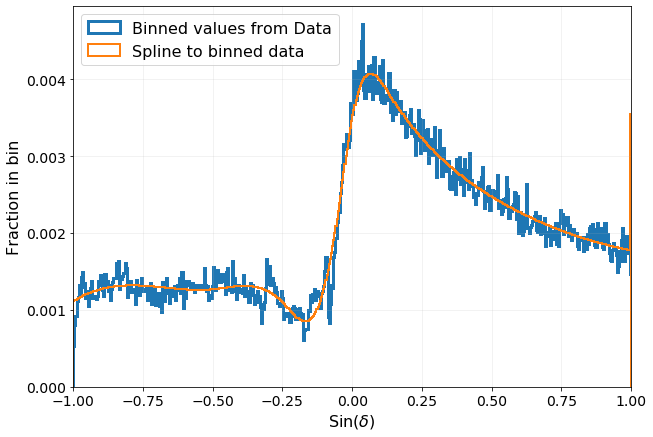

In [9]:
# Our background PDF only depends on declination.
# In order for us to capture the dec-dependent
# behavior, we first take a look at the dec values
# in the data. We can do this by histogramming them.
fig, ax = plt.subplots(figsize=(10, 7))

sin_dec = np.sin(data['dec'])
bins = np.linspace(-1.0, 1.0, 501)

# Make the background histogram. Note that we do NOT
# want to use density=True here, since that would mean
# that our spline depends on the original bin widths!
hist, bins, _ = ax.hist(sin_dec, 
                        bins=bins, 
                        histtype='step', 
                        linewidth=3,
                        weights=np.ones_like(data['dec'])/len(data['dec']),
                        label='Binned values from Data')

# These values have a lot of "noise": they jump
# up and down quite a lot. We could use fewer
# bins, but that may hide some features that
# we care about. We want something that captures
# the right behavior, but is smooth and continuous.
# The best way to do that is to use a "spline",
# which will fit a continuous and differentiable
# piecewise polynomial function to our data. 
# We can set a smoothing factor (s) to control
# how smooth our spline is.
bg_p_dec = interpolate.UnivariateSpline(bins[:-1]+np.diff(bins)/2., 
                                        hist,
                                        bbox=[-1.0, 1.0],
                                        s=1.5e-5,
                                        ext=1)

# Plot this too, so we can see how it compares
# to the histogram.
bg_p_dec_hist, bins, _ = ax.hist(bins, 
                                 bins=bins,
                                 weights=bg_p_dec(bins), 
                                 histtype='step',
                                 linewidth=2,
                                 label = 'Spline to binned data')

ax.legend(loc='upper left', fontsize=16)
ax.grid(alpha=0.2)
ax.set_xlim(-1, 1)
ax.set_xlabel(r'Sin($\delta$)', fontsize=16,)
ax.set_ylabel("Fraction in bin", fontsize=16)
ax.tick_params(labelsize=14)

In [10]:
# To get the declination-dependent background PDF,
# we can now just call the background spline. Note
# that we splined in sin(dec), so we need to pass
# that to the spline. 
def background_pdf(event,
                   test_ra, 
                   test_dec):
    background_likelihood = (1/(2*np.pi))*bg_p_dec(np.sin(event['dec']))
    return background_likelihood

In [11]:
def create_interpolated_ratio(gamma,data=data,sim=sim,bins=[np.linspace(-1,1,100),np.linspace(1,8,100)]):
    bg_w=np.ones(len(data),dtype=float)
    bg_w/=np.sum(bg_w)
    bg_h,xedges,yedges=np.histogram2d(np.sin(data['dec']),data['logE'],bins=bins
                                      ,weights=bg_w)
    
    sig_w=sim['ow']*sim['trueE']**gamma
    sig_w/=np.sum(sig_w)
    sig_h,xedges,yedges=np.histogram2d(np.sin(sim['dec']),sim['logE'],bins=bins
                                      ,weights=sig_w)
    ratio=sig_h/bg_h
    for i in range(ratio.shape[0]):
        values=ratio[i]
        good=np.isfinite(values)&(values>0)
        x,y=bins[1][:-1][good],values[good]
        spline=scipy.interpolate.UnivariateSpline(x,y,k=1,s=0,ext=3)
        ratio[i]=spline(bins[1][:-1])
    return ratio,bins

def evaluate_interpolated_ratio(events,ratio,bins=bins):
    i=np.searchsorted(bins[0],np.sin(events['dec']))
    j=np.searchsorted(bins[1],np.sin(events['logE']))
    return ratio[i-1,j-1]

# Our events will consist of some unknown combination
# of signal events (described by the PDF "signal_pdf", S)
# and background events (described by "background_pdf", B).
# We'll call the number of signal events ns.
# Then the total likelihood will therefore be 
#
# L_i = (ns/N)*S + (nb/N)*B
#     = (ns/N)*S + ((N-ns)/N)*B
#
# which we will sum over all events i in our trial.
# We'll evaluate these at a "test point" in RA, dec.
def spatial_llh(event,
                test_ra,
                test_dec,
                ratio,bins,
                ns = 0,minimize=0):
    N = len(event)
    if N==0: 
        llh=0
        fit_ns=0
        return llh,[fit_ns,]
    
    # Check: ns cannot be larger than N.
    if ns > N: 
        ns = N-0.0001
    ns=float(ns)
    S = signal_pdf(event, test_ra, test_dec)
    B = background_pdf(event, test_ra, test_dec)
    energy=evaluate_interpolated_ratio(event,ratio=ratio,bins=bins)
    
    def get_ts(fit_ns):
        ts=np.log(1+((fit_ns/N)*(S*energy/B-1)))
        ts[~np.isfinite(ts)]=0
        return -2*np.sum(ts)
    if minimize:
        results=scipy.optimize.minimize(get_ts,x0=[ns,],bounds=[[0,N]],method="SLSQP")
        if results.fun>0:
            return 0,results.x
        return -1*results.fun,results.x
    #ratio[ratio==0]=1
    else:
        ts=get_ts(ns)
        return -1*ts,[ns,]
    # This is the *likelihood*..
    # We want the negative log-likelihood
    #return np.sum(np.log(ratio))

In [12]:
def produce_n_trials(ntrials,
                        
                     # Parameters to control the true signal, background
                     n_background = n_expected, 
                     N=0, 
                     gamma=-2, 
                     source_ra = np.pi/2, 
                     source_dec = np.pi/6, 
                     
                     # Parameters to control where/when you look
                     test_ns = 0,
                     test_ra = np.pi/2,
                     test_dec = np.pi/6,
                     window = time_window, 
                     minimize=0,
                     # The data to use
                     data=data, 
                     sim=sim, 
                     random_seed = None,
                     verbose=True):
    
    llhs = []
    ratio,bins=create_interpolated_ratio(gamma=gamma,data=data,sim=sim,bins=[np.linspace(-1,1,100),np.linspace(1,8,100)])
    for i in range(ntrials):
        # Get the events for this trial.
        trial = produce_trial(n_background=n_expected, 
                               N=N, 
                               gamma=gamma, 
                               source_ra=source_ra, 
                               source_dec=source_dec, 
                               window=time_window, 
                               data=data, 
                               sim=sim, 
                               random_seed = random_seed)

        # And the likelihood for the trial
        llh = spatial_llh(trial, 
                          test_ra, 
                          test_dec,ratio=ratio,bins=bins,
                          ns = test_ns,minimize=minimize,
                          )
        llhs.append(llh)
    return np.array(llhs)

In [13]:
def torad(degree):
    return degree*pi/180
def bisection(n_trials,gamma=-2,n_background = n_expected, 
                     source_ra = np.pi/2, 
                     source_dec = np.pi/6, 
                     
                     # Parameters to control where/when you look
                     test_ns = 1,
                     test_ra = np.pi/2,
                     test_dec = np.pi/6,
                     window = time_window, 
                     minimize=0,
                     # The data to use
                     data=data, 
                     sim=sim, 
                     random_seed = None,):
    down=0
    up=1e-16
    background_ts=produce_n_trials(10000,N=0,gamma=gamma,source_ra=source_ra,source_dec=source_dec,test_ns=test_ns,test_ra=test_ra,test_dec=test_dec,window = window, 
                     minimize=minimize,
                     # The data to use
                     data=data, 
                     sim=sim)
    background_3sigma=np.percentile(background_ts[:,0],99.73)
    background_median=np.percentile(background_ts[:,0],50)
    test=produce_n_trials(n_trials,N=up,gamma=gamma,source_ra=source_ra,source_dec=source_dec,test_ns=test_ns,test_ra=test_ra,test_dec=test_dec,window = window, 
                     minimize=minimize,
                     # The data to use
                     data=data, 
                     sim=sim)
    while np.percentile(test[:,0],50)<background_3sigma:
        up=up*10
        test=produce_n_trials(n_trials,N=up,gamma=gamma,source_ra=source_ra,source_dec=source_dec,test_ns=test_ns,test_ra=test_ra,test_dec=test_dec,window = window, 
                     minimize=minimize,
                     # The data to use
                     data=data, 
                     sim=sim)
    stop=up*1e-3
    discovery=0
    discovery_bool=True
    while discovery_bool:
        if up-down<stop:#np.percentile(test,50)>background_3sigma:
            discovery=signal_n
            discovery_bool=False
        else:
            signal_n=(up+down)/2
            test=produce_n_trials(n_trials,N=signal_n,gamma=gamma,source_ra=source_ra,source_dec=source_dec,test_ns=test_ns,test_ra=test_ra,test_dec=test_dec,window = window, 
                         minimize=minimize,
                         # The data to use
                         data=data, 
                         sim=sim)
            if np.percentile(test[:,0],50)>background_3sigma:
                up=signal_n
            else:
                down=signal_n
    up=1e-16
    down=0
    test=produce_n_trials(n_trials,N=up,gamma=-2,source_ra=source_ra,source_dec=source_dec,test_ns=test_ns,test_ra=test_ra,test_dec=test_dec,window = window, 
                     minimize=minimize,
                     # The data to use
                     data=data, 
                     sim=sim)
    while np.percentile(test[:,0],10)<=background_median:
        up=up*10
        test=produce_n_trials(n_trials,N=up,gamma=gamma,source_ra=source_ra,source_dec=source_dec,test_ns=test_ns,test_ra=test_ra,test_dec=test_dec,window = window, 
                     minimize=minimize,
                     # The data to use
                     data=data, 
                     sim=sim)
    stop=up*1e-3
    sen=0
    sen_bool=True
    while sen_bool:
        if up-down<stop:#np.percentile(test,50)>background_3sigma:
            sen=signal_n
            up=signal_n
            down=0
            sen_bool=False
        else:
            signal_n=(up+down)/2
            test=produce_n_trials(n_trials,N=signal_n,gamma=gamma,source_ra=source_ra,source_dec=source_dec,test_ns=test_ns,test_ra=test_ra,test_dec=test_dec, window = window, 
                         minimize=minimize,
                         # The data to use
                         data=data, 
                         sim=sim)

            if np.percentile(test[:,0],10)>background_median:
                up=signal_n
            else:
                down=signal_n
    return discovery,sen



47 46


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in log


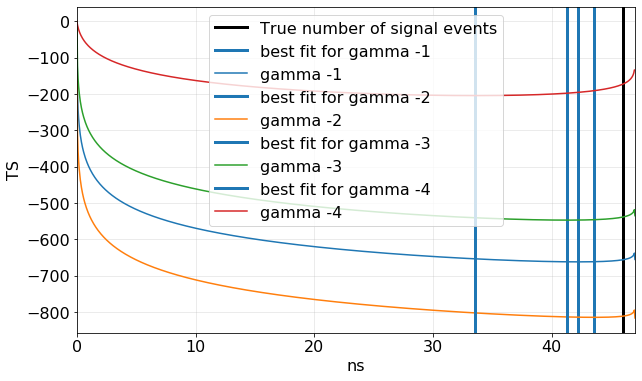

In [14]:
trial = produce_trial(N=1e-14,gamma=-2)

# How many signal events are there really in this trial?
# Use a trick of this dataset to ID signal events.
# This works since the simulated events have the
# runs set to very large numbers while the data
# (our background events) have values below 200,000.
ns_true = (trial['run']>200000).sum()
print(len(trial['run']), ns_true)
ns_values = np.linspace(0, len(trial), 1000)
ts_values = []
fig, ax = plt.subplots(figsize=(10,6))
ax.axvline(ns_true,
            color='k',
           linewidth=3,
            label = 'True number of signal events')

for gamma in [-1,-2,-3,-4]:
    ts_values=[]
    ratio,bins=create_interpolated_ratio(gamma=gamma,data=data,sim=sim,bins=[np.linspace(-1,1,100),np.linspace(1,8,100)])
    for ns in ns_values:
        # Calculate the spatial LLH for this ns and trial
        # How do we call the spatial likelihood for this
        # trial and ns with a source at RA=pi/2, dec=pi/6?
        llh = spatial_llh(trial, 
                              pi/2, 
                              pi/6,ratio=ratio,bins=bins,
                              ns = ns,minimize=0
                              )

        ts_values.append(-llh[0])
    llhmin = spatial_llh(trial, 
                              pi/2, 
                              pi/6,ratio=ratio,bins=bins,
                              minimize=1
                              )
    # numpy arrays are easier to do calculations with than lists
    ts_values = np.array(ts_values)
    ax.axvline(llhmin[1],
           linewidth=3,
            label = 'best fit for gamma '+str(gamma))

    ax.plot(ns_values,ts_values,label = 'gamma '+str(gamma))
ax.grid(alpha=0.3)
ax.set_xlim(0, len(trial))
ax.legend(fontsize=16,)
ax.set_xlabel("ns", fontsize=16)
ax.set_ylabel("TS", fontsize=16)
ax.tick_params(which='both', labelsize=16)

In [15]:
trial = produce_trial(N=1e-14,gamma=-2)

# How many signal events are there really in this trial?
# Use a trick of this dataset to ID signal events.
# This works since the simulated events have the
# runs set to very large numbers while the data
# (our background events) have values below 200,000.
ns_true = (trial['run']>200000).sum()
print(len(trial['run']), ns_true)
ns_values = np.linspace(0, len(trial), 1000)
ts_values = []
total=[]
gammalist=np.linspace(-1,-4,25)
for gamma in gammalist:
    ts_values=[]
    ratio,bins=create_interpolated_ratio(gamma=gamma,data=data,sim=sim,bins=[np.linspace(-1,1,100),np.linspace(1,8,100)])
    for ns in ns_values:
        # Calculate the spatial LLH for this ns and trial
        # How do we call the spatial likelihood for this
        # trial and ns with a source at RA=pi/2, dec=pi/6?
        
        llh = spatial_llh(trial, 
                              pi/2, 
                              pi/6,ratio=ratio,bins=bins,
                              ns = ns,minimize=0
                              )

        ts_values.append(-llh[0])
    total.append(ts_values)
    # numpy arrays are easier to do calculations with than lists
#np.save("totalts.npy",np.array(total))


53 49


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log


In [32]:
indexdiff=[]
for i in range(100):
    trial = produce_trial(N=1e-14,gamma=-2)

    # How many signal events are there really in this trial?
    # Use a trick of this dataset to ID signal events.
    # This works since the simulated events have the
    # runs set to very large numbers while the data
    # (our background events) have values below 200,000.
    ns_true = (trial['run']>200000).sum()
    print(len(trial['run']), ns_true)
    ns_values = np.linspace(0, len(trial), 1000)
    ts_values = []
    total=[]
    gammalist=np.linspace(-1,-4,25)
    for gamma in gammalist:
        ts_values=[]
        ratio,bins=create_interpolated_ratio(gamma=gamma,data=data,sim=sim,bins=[np.linspace(-1,1,100),np.linspace(1,8,100)])
        for ns in ns_values:
            # Calculate the spatial LLH for this ns and trial
            # How do we call the spatial likelihood for this
            # trial and ns with a source at RA=pi/2, dec=pi/6?

            llh = spatial_llh(trial, 
                                  pi/2, 
                                  pi/6,ratio=ratio,bins=bins,
                                  ns = ns,minimize=0
                                  )

            ts_values.append(-llh[0])
        total.append(ts_values)
    total=np.array(total)
    indexdiff.append(gammalist[np.unravel_index(np.argmin(total, axis=None), total.shape)[0]])
    # numpy arrays are easier to do calculations with than lists
#np.save("totalts.npy",np.array(total))
indexdiff=np.array(indexdiff)
np.save("indexdiff.npy",np.array(indexdiff))

41 36


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log


45 38
40 34
31 25
44 41
38 33
43 38
37 34
53 46
52 49
41 39
37 33
35 32
36 32
35 30
49 45
42 39
51 45
46 43
40 38
40 37
40 38
39 36
49 45
36 30
45 37
38 34
43 39
35 32
38 33
49 44
45 38
35 33
36 33
47 42
33 32
43 39
50 45
41 35
42 36
35 33
36 34
51 49
47 39
49 47
35 32
38 37
48 48
38 33
43 37
46 43
50 42
39 33
50 47
35 30
42 36
50 48
32 29
44 41
31 30
38 32
41 38
32 32
35 32
50 44
45 41
40 39
47 36
31 29
36 34
49 46
31 29
39 33
42 37
55 51
37 35
43 42
52 47
58 53
34 29
34 31
51 47
39 37
43 40
38 35
46 42
50 46
47 35
47 38
31 30
40 38
32 27
35 33
40 37
47 44
42 38
49 46
24 21
27 26
44 41


In [39]:
total


array([[  -0.        , -224.70819745, -271.11390565, ..., -710.88094715,
        -706.80109883, -748.32058159],
       [  -0.        , -262.37609281, -310.82312262, ..., -757.19880243,
        -753.12039624, -794.64132155],
       [  -0.        , -297.91009891, -347.88686322, ..., -799.0556305 ,
        -794.97796113, -836.49962273],
       ...,
       [  -0.        ,  -30.55975993,  -46.73676363, ..., -336.76630649,
        -332.41423263, -373.63528989],
       [  -0.        ,  -21.51415174,  -33.97627859, ..., -290.1484488 ,
        -285.57022867, -326.48735671],
       [  -0.        ,  -14.92207399,  -24.31646237, ..., -243.99789679,
        -239.09846513, -279.45202979]])

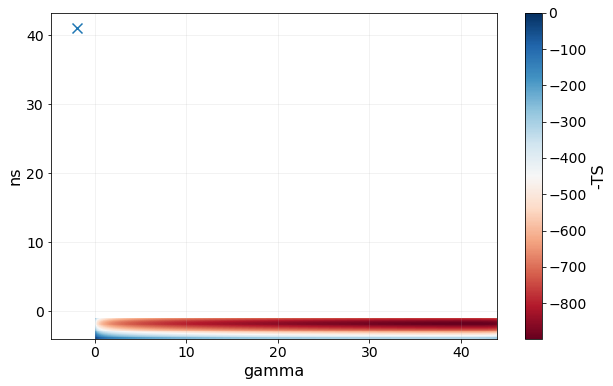

In [40]:
gammalist=np.linspace(-1,-4,25)
#total=np.load("totalts.npy")
fig, ax = plt.subplots(figsize=(10,6))
cmesh = ax.pcolormesh(ns_values,gammalist , total,
                     cmap = 'RdBu')
cbar = plt.colorbar(cmesh, ax=ax)
ax.scatter(ns_true,marker='x',s=100)
ax.grid(alpha=0.2)
ax.set_xlabel(r"gamma", fontsize=16)
ax.set_ylabel(r"ns", fontsize=16)
ax.tick_params(which='both', labelsize=14)
#ax.set_title()
cbar.ax.set_ylabel("-TS", fontsize=16)
cbar.ax.tick_params(labelsize=14)

In [17]:
import numpy as np

def ra(h, m, s):
    return (h*15 + m/4 + s/240)*np.pi/180

def dec(sign, deg, m, s):
    return sign*(deg + m/60 + s/3600)*np.pi/180

crab_nebula = {'ra':ra(5, 34, 31.94), 'dec':dec(1, 22, 0, 52.2)}
txs         = {'ra':ra(5, 9, 25.9645434784), 'dec':dec(1, 5, 41, 35.333636817)}
m77         = {'ra':ra(2, 42, 40.771), 'dec':dec(-1, 0, 0, 47.84)}
mgro1908    = {'ra':ra(19, 7, 54), 'dec':dec(1, 6, 16, 7)}
sag_a_star  = {'ra':ra(17, 45, 40.0409), 'dec':dec(-1, 29, 0, 28.118),}
mag_l       = {'ra':ra(5, 23, 34.5), 'dec':dec(-1, 69, 45, 22)}
mag_s       = {'ra':ra(0, 52, 44.8), 'dec':dec(-1, 72, 49, 43)}
ra_list=[ra(5, 34, 31.94),ra(5, 9, 25.9645434784),ra(2, 42, 40.771),ra(19, 7, 54),ra(17, 45, 40.0409),ra(5, 23, 34.5),ra(0, 52, 44.8)]
dec_list=[dec(1, 22, 0, 52.2),dec(1, 5, 41, 35.333636817),dec(-1, 0, 0, 47.84),dec(1, 6, 16, 7),dec(-1, 29, 0, 28.118),dec(-1, 69, 45, 22),dec(-1, 72, 49, 43)]

In [18]:
def produce_n_trials_stack(ntrials,
                        
                     # Parameters to control the true signal, background
                     n_background = n_expected, 
                     N=0, 
                     gamma=-2, 
                     source_ra = [np.pi/2], 
                     source_dec = [np.pi/6], 
                     
                     # Parameters to control where/when you look
                     test_ns = 0,
                     test_ra = [np.pi/2],
                     test_dec = [np.pi/6],
                     window = time_window, 
                     minimize=0,
                     # The data to use
                     data=data, 
                     sim=sim, 
                     random_seed = None,
                     verbose=True):
    
    llhs = []
    ratio,bins=create_interpolated_ratio(gamma=gamma,data=data,sim=sim,bins=[np.linspace(-1,1,100),np.linspace(1,8,100)])
    for i in range(ntrials):
        # Get the events for this trial.
        ts=[0,0]
        for j in range(len(test_ra)):
            test_ra_temp=test_ra[j]
            test_dec_temp=test_dec[j]
            source_ra_temp=source_ra[j]
            source_dec_temp=source_dec[j]
            trial = produce_trial(n_background=n_expected, 
                                   N=N, 
                                   gamma=gamma, 
                                   source_ra=source_ra_temp, 
                                   source_dec=source_dec_temp, 
                                   window=time_window, 
                                   data=data, 
                                   sim=sim, 
                                   random_seed = random_seed)

            # And the likelihood for the trial
            llh = spatial_llh(trial, 
                              test_ra_temp, 
                              test_dec_temp,ratio=ratio,bins=bins,
                              ns = test_ns,minimize=minimize,
                              )
            ts[0]=ts[0]+llh[0]
            ts[1]=ts[1]+llh[1][0]
        llhs.append(ts)
    return np.array(llhs)